# Initialize table and data from file

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# plot table
import texttable as tt

def plotTable(headers,
              rows,
              valign=True,
              column_width=False,
              no_deco=False,
              precision=1):
    tab = tt.Texttable()
    if len(headers) > 0:
        tab.header(headers)
    tab.set_precision(precision)
    for row in rows:
        tab.add_row(row)

    if valign and len(headers) > 0:
        tab.set_cols_valign(['m'] * len(headers))

    if column_width:
        columns = [0] * len(rows[0])
        for row in rows:
            for i, cell in enumerate(row):
                if isinstance(row[i], str):
                    columns[i] = max(
                        columns[i],
                        max([len(line) for line in row[i].split('\n')]))
        for i, head in enumerate(headers):
            columns[i] = max(columns[i], len(head))
        tab.set_cols_width(columns)

    if no_deco:
        tab.set_deco(tt.Texttable.HEADER | tt.Texttable.VLINES)

    s = tab.draw()
    return s

def data_from_file(file_name,case):
    #case = 1-> Id from file. Iq in 0->220 > 'i_direct_flux'
    #case = 2 -> Iq from file. Id in 0->220 > 'j_q_flux'
    data = np.loadtxt(file_name)
    ids = data[0, :]    
    dfs = data[1:, :]
    iqs = list(range(220, -1, -20))
    if case == 1:
        xLabel = 'Id'
        yLabel = 'direct flux'
        Is = 'Iq'
    elif case == 2:
        xLabel = 'Iq'
        yLabel = 'quadratic flux'  
        Is = 'Id'
    return ids, dfs, iqs, xLabel, yLabel, Is


ids, dfs, iqs, xLabel, yLabel, Is = data_from_file('i_direct_flux', 1)

# Plot all Iqs curves

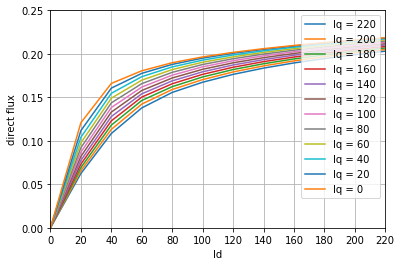

In [34]:
# plt.rcParams["figure.figsize"] = [12, 8]

for idx in range(0, 12):
    df = dfs[:, idx]
    plt.plot(ids, df, label='Iq = %d' %iqs[idx])
    plt.ylim([0, 0.25])
    plt.xlim([0, 220])
    plt.xticks(ids)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.legend(loc='best')
plt.grid()
plt.show()

# Cubic spline interpolation

In [3]:
#cubic spline interpolation

from scipy.interpolate import interp1d
from scipy import interpolate
import itertools
import sys

ids, dfs, iqs, xLabel, yLabel, Is = data_from_file('i_direct_flux', 1)

def sum_squared_error(gr, pred):
    gr = np.array(gr)
    pred = np.array(pred)
    return (10 ** 6) * (1 / gr.shape[0]) * sum((gr - pred) ** 2)

curve_indices = list(range(0, 12)) 
curves_for_plot = list(range(1, 13,2))
pts_for_plot = [6,5,4]

# try interpolating with only 10, 9, 8 ... 4, 3 points
sub_points_num  = list(range(len(ids)-1, 3, -1))

headers = ['%s' %Is] + ['pts num: %d' % pts for pts in sub_points_num] + [' ################ best_pts ########']
rows = []
x_best_5_pts = []
y_best_5_pts = []

for curve in curve_indices: #pentru fiecare curba Iq
    y = dfs[:, curve] #iau fluxurile corespunzatoare
    x = ids #iau id-urile
        
    tck = interpolate.splrep(x, y, s=0) #face spline pe toate cele 12 puncte
    x_new = np.linspace(min(x), max(x), 200)
        
    # baseline = y values obtained when interpolating with all ground truth points
    baseline = interpolate.splev(x_new, tck, der=0)
    
    row = ['%s %d' % (Is, iqs[curve])]
    best_5_points =[]
   
    for points_num in sub_points_num:
        # store best configuration
        best_pts     = (x, y)
        best_interp  = (x_new, baseline)
        best_error   = sys.float_info.max
        best_err_gr  = sys.float_info.max
    
        sub_points_sets = itertools.combinations(range(len(ids)), points_num)
        for pts in sub_points_sets:
            pts = list(pts)
            x_     = x[pts]
            y_     = y[pts]
            tck_   = interpolate.splrep(x_, y_, s=0)
            y_new_ = interpolate.splev(x_new, tck_, der=0)            
        
            # error -- difference between baseline interp curve and current one
            error = sum_squared_error(baseline, y_new_)
            
            if error < best_error:
                best_error  = error
                best_pts    = (x_, y_) # best points from combination
                best_interp = (x_new, y_new_) # best points from interpolation
                
                # interpolate in target points + evaluate error
                gr_interp = interpolate.splev(x, tck_, der=0)
                best_err_gr = sum_squared_error(y, gr_interp)
        
        if points_num == 5:
            best_5_points = best_pts[0]
            x_best_5_pts.append(best_pts[0])#to be used for linear interp
            y_best_5_pts.append(best_pts[1])#to be used for linear interp
            
        row.append(best_err_gr)
        
#         if curve in curves_for_plot and points_num in pts_for_plot:
#             print('%s: %d, pts num: %d' % (Is,iqs[curve], points_num))
#             plt.clf()
#             plt.scatter(x, y, label='orig points')
#             plt.plot(x_new, baseline, label='original spline')
#             plt.scatter(best_pts[0], best_pts[1], label='best pts')
#             plt.plot(best_interp[0], best_interp[1], label='best interp')

#             plt.ylim([0, 0.25])
#             plt.xlim([0, 220])
#             plt.xticks(ids)
#             plt.xlabel(xLabel)
#             plt.ylabel(yLabel)
#             plt.legend(loc='best')
#             plt.title('%s : %d, pts_num: %d' % (Is,iqs[curve], points_num))
#             plt.grid()
#             plt.show()
    
    row.append(best_5_points)
    rows.append(row)
    

# print('Interpolation error ( sum squared error * 10 ^ 6)')
# table = plotTable(headers=headers, rows=rows, column_width=True, precision=5)
# print(table)


# Det. nr minim de curbe Iq necesar pentru a genera toate celelalte 12 curbe
 


In [ ]:
# curves_for_plot = [5] #list(range(0, 13,5))
# curves_num_for_plot = [5]

# try interpolating with only 11, 9, 8 ... 4, 3 curves
config_curves_num  = list(range(2,len(ids)-1))

#keep errors for each curve in all config
error_for_all_curves = [sys.float_info.max] * len(ids)
best_err_gr          = [sys.float_info.max] * len(ids)
best_config          = [[] for i in range(len(ids))]

for curves_num in config_curves_num:#pt fiecare nr de curbe din 11,10,...3
    
    sub_curves_sets = itertools.combinations(range(len(ids)), curves_num) #calculez combinatiile
           
    for iq_curves_idx in sub_curves_sets: #pt fiecare combinatie/configuratie
        
        iq_curves_idx = list(iq_curves_idx) #transform in indici (din iterator)
      
#         #construiesc sirurile de puncte pentru interpolare liniara
        x_lin = [[] for i in range(5)] 
        y_lin = [[] for i in range(5)]
        for idx in iq_curves_idx: #pt fiecare curba din configuratie
            for i in list(range(0,5)): # adaug fiecare best_5_pts la sirul coresp
                x_lin[i].append(x_best_5_pts[idx][i]) #primul x_lin = toate primele x_5_best_pts 
                                                  #al curb din config
                y_lin[i].append(y_best_5_pts[idx][i])

        # daca faci ca mai sus, o sa ajungi sa ai 2 curbe cu 2 seturi diferite de puncte
        # scopul e sa interplezi intre 2 seturi de puncte care au aceeasi semnificatie altfel pierzi sensul interpolarii
        # adica pentru fiecare curba din iq_curve_idx ar trebuie sa ai [vector 5 pct] aceleasi puncte!!
        
        for curve in curve_indices:
            y_approx = []

            #approximez liniar fluxul pt fiecare x_best_5_pts pt fiecare Iq in [220 ... 0]
            for index in range(5):
                # trebuie sa schimbi
                # scrie formula interpolatii lineare nu mai fa cu np.interp
                y_approx.append(np.interp(x_best_5_pts[curve][index], x_lin[index],y_lin[index]))
   
            
    
            #!!!!!!!!!INTERPOLARE SPLINE!!!!!! pt (x_5_best_points[curve], y_approx[curve]) 
            
            y = dfs[:, curve] #iau fluxurile corespunzatoare
            x = ids #iau id-urile

            tck = interpolate.splrep(x, y, s=0) #face spline pe toate cele 12 puncte
            x_new = np.linspace(min(x), max(x), 200)

            # baseline = y values obtained when interpolating with all ground truth points
            baseline = interpolate.splev(x_new, tck, der=0)
                      
            
            
            # store best configuration
            best_pts     = (x, y)
            best_interp  = (x_new, baseline)
#             best_error   = sys.float_info.max
#             best_err_gr  = sys.float_info.max    
                                  
            x_     = x_best_5_pts[curve]
            y_     = y_approx
            tck_   = interpolate.splrep(x_, y_, s=0)
            y_new_ = interpolate.splev(x_new, tck_, der=0)    
            
            # error -- difference between baseline interp curve and current one
            error = sum_squared_error(baseline, y_new_)
            
            if error < error_for_all_curves[curve]:
                error_for_all_curves[curve] = error
                best_config[curve].append([iqs[j] for j in iq_curves_idx])
                best_pts                    = (x_, y_)
                best_interp                 = (x_new, y_new_)
                
                # interpolate in target points + evaluate error
                gr_interp = interpolate.splev(x, tck_, der=0)
                best_err_gr [curve] = sum_squared_error(y, gr_interp)
      
    
    headers = ['%s' %Is] + ['no of curves'] + ['#####error#####'] + ['#########best config#########']
    rows    = []
    for idx in range(12):
        row = ['%s %d' % (Is, iqs[idx])]
        row.append(curves_num)
        row.append(best_err_gr[idx])
        row.append(best_config[idx][-1])
        rows.append(row)

    print('Interpolation error ( sum squared error * 10 ^ 6)')
    table = plotTable(headers=headers, rows=rows, column_width=True, precision=5)
    print(table)
    print()
    print()

# Linear interp with one dataset of best-pts


Iq: 200, curves num: 2


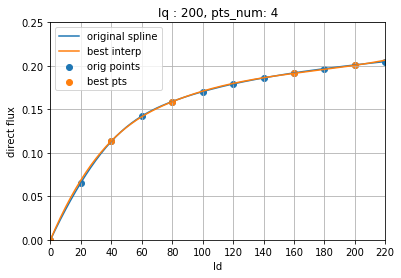

Iq: 200, curves num: 3


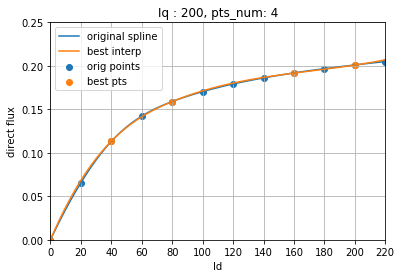

Iq: 200, curves num: 4


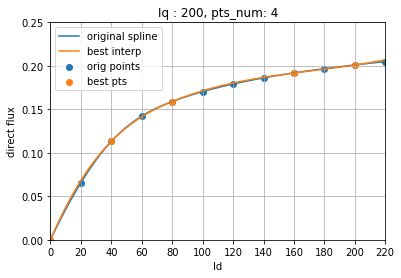

Iq: 200, curves num: 5


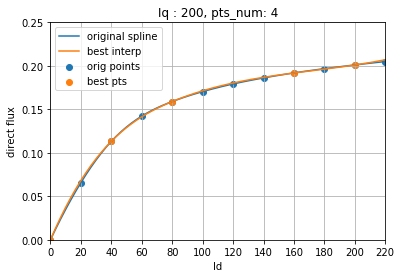

Iq: 200, curves num: 6


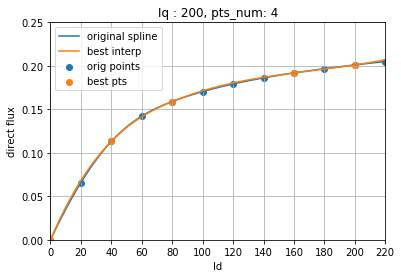

Iq: 180, curves num: 2


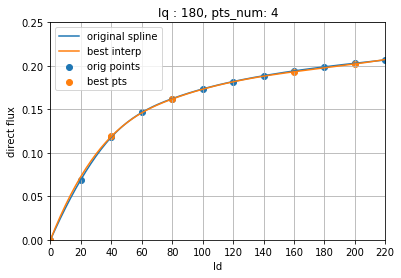

Iq: 180, curves num: 3


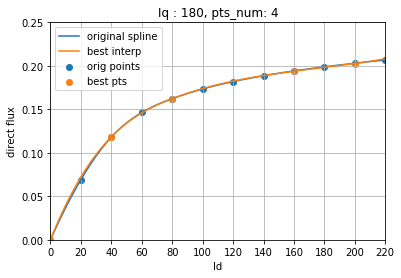

Iq: 180, curves num: 4


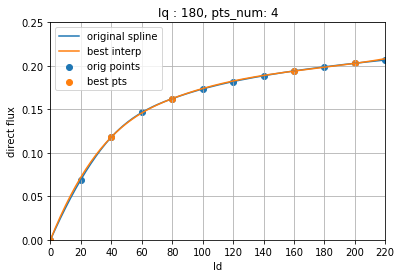

Iq: 180, curves num: 5


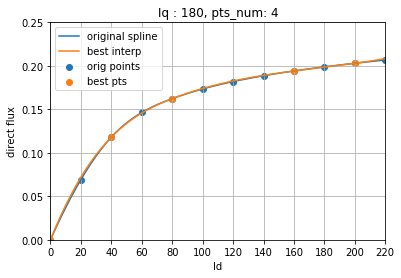

Iq: 180, curves num: 7


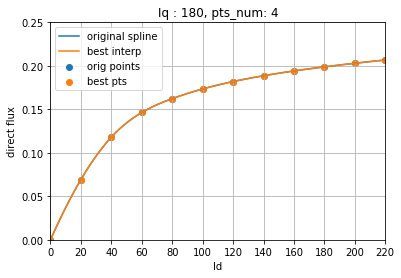

Iq: 160, curves num: 2


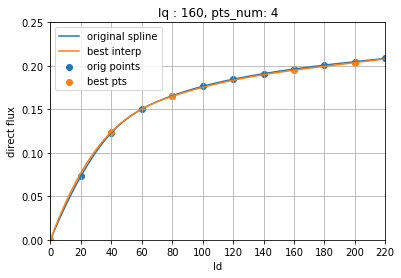

Iq: 160, curves num: 3


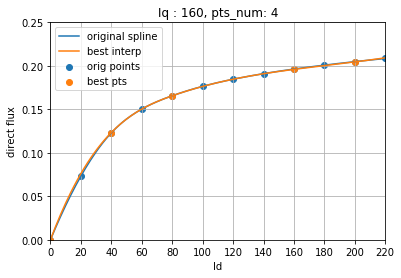

Iq: 160, curves num: 4


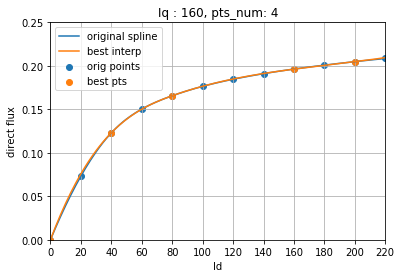

Iq: 160, curves num: 6


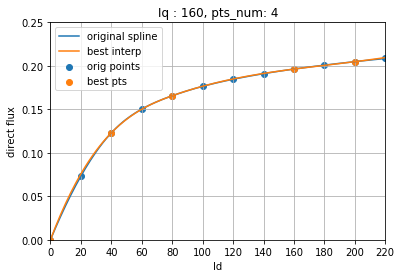

Iq: 160, curves num: 7


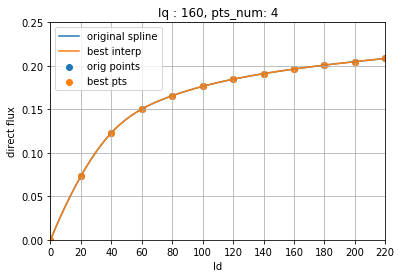

Iq: 140, curves num: 2


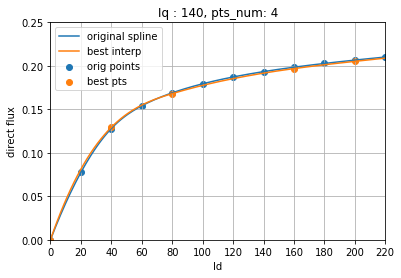

Iq: 140, curves num: 3


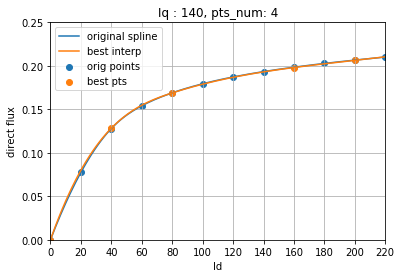

Iq: 140, curves num: 5


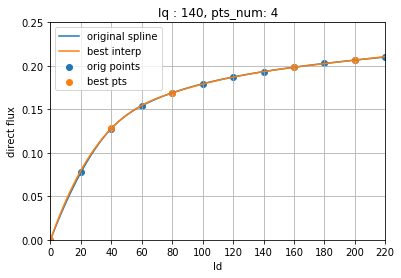

Iq: 140, curves num: 7


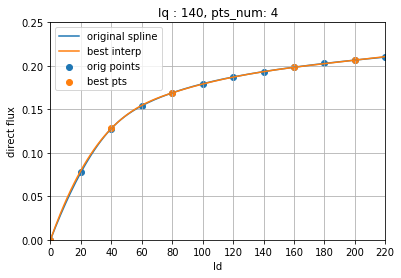

Iq: 120, curves num: 2


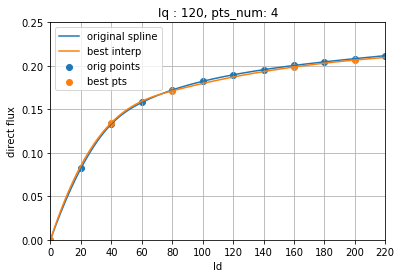

Iq: 120, curves num: 3


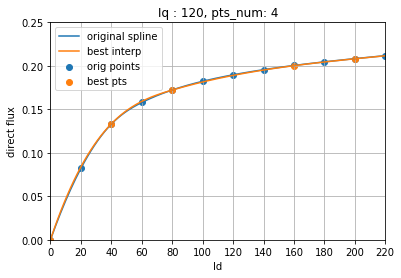

Iq: 120, curves num: 4


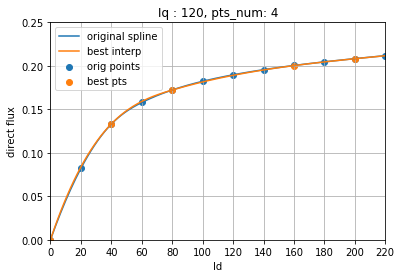

Iq: 120, curves num: 5


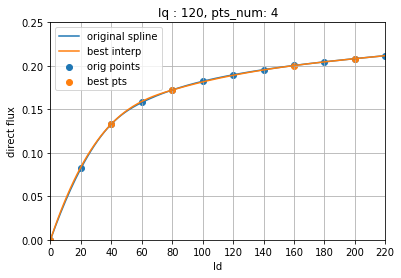

Iq: 120, curves num: 6


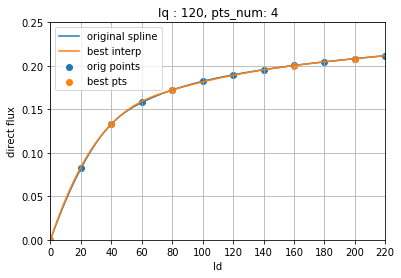

Iq: 100, curves num: 2


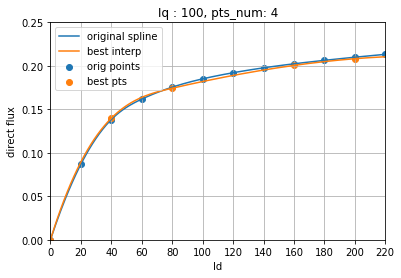

Iq: 100, curves num: 4


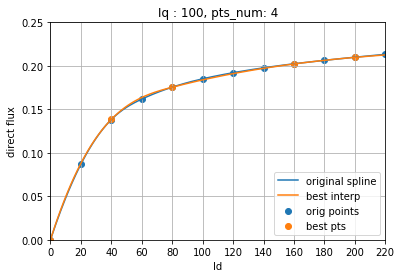

Iq: 80, curves num: 2


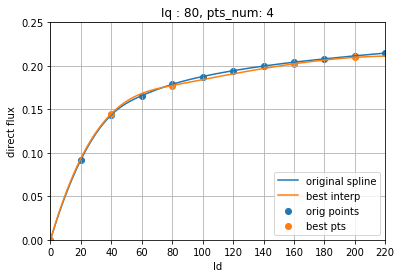

Iq: 80, curves num: 3


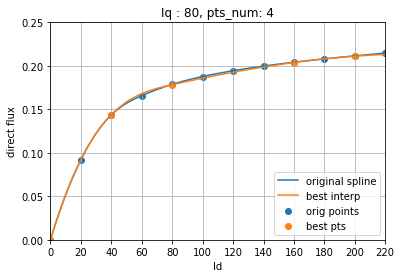

Iq: 80, curves num: 4


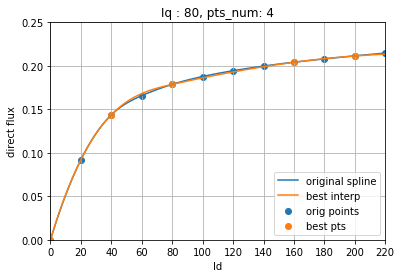

Iq: 80, curves num: 5


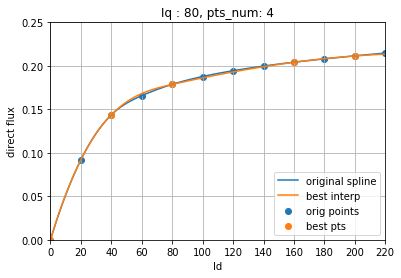

Iq: 80, curves num: 6


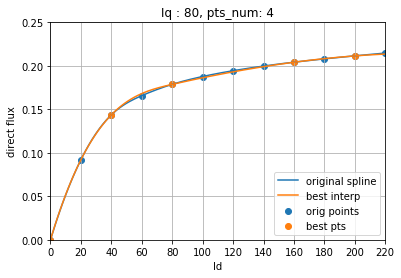

Iq: 60, curves num: 2


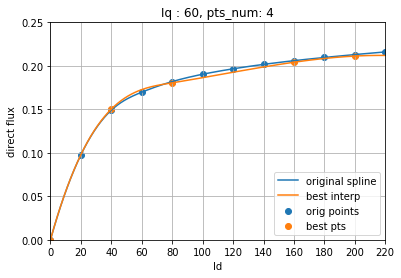

Iq: 60, curves num: 3


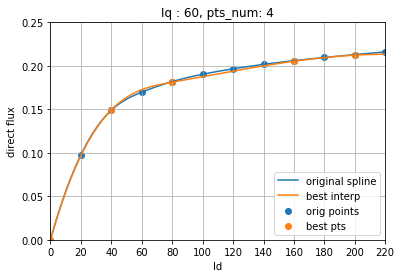

Iq: 60, curves num: 5


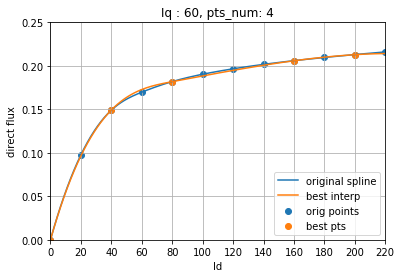

Iq: 60, curves num: 7


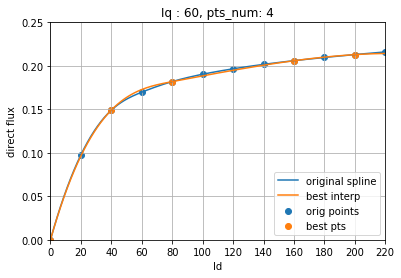

Iq: 40, curves num: 2


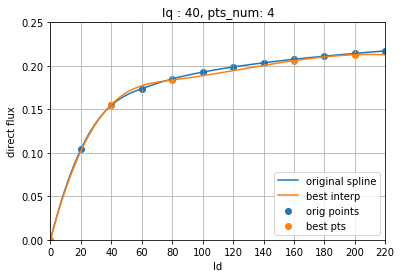

Iq: 40, curves num: 3


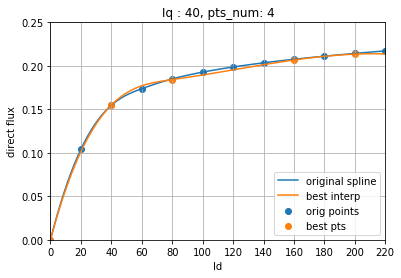

Iq: 40, curves num: 4


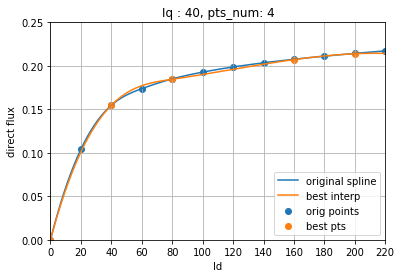

Iq: 40, curves num: 6


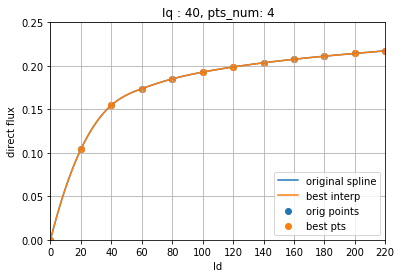

Iq: 20, curves num: 2


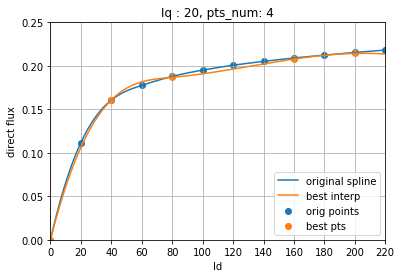

Iq: 20, curves num: 3


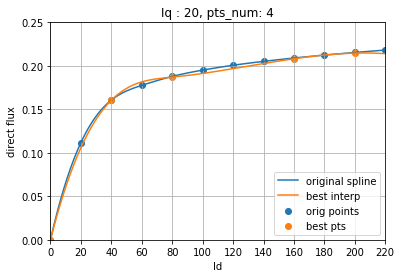

Iq: 20, curves num: 4


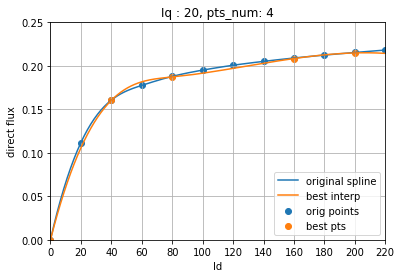

Iq: 20, curves num: 5


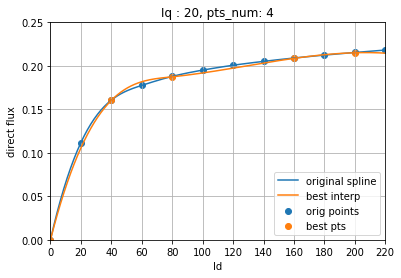

Iq: 20, curves num: 6


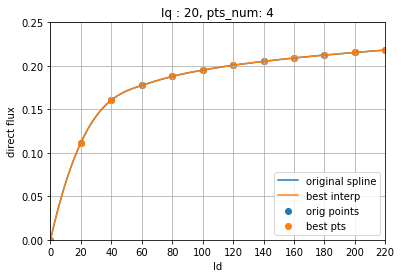

Iq: 20, curves num: 7


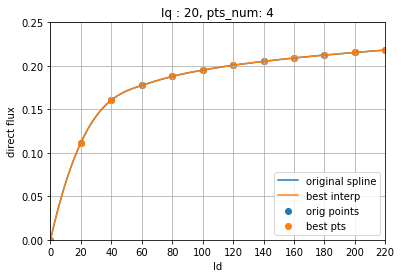

+--------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+---------------------------------+
|   Iq   |  no of curves: 2  |  no of curves: 3  |  no of curves: 4  |  no of curves: 5  |  no of curves: 6  |  no of curves: 7  | best no of curves | ######### best config ######### |
+========+===================+===================+===================+===================+===================+===================+===================+=================================+
| Iq 220 | curve from config | curve from config | curve from config | curve from config | curve from config | curve from config | 0                 | []                              |
+--------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+---------------------------------+
| Iq 200 | 1.18987           | 1.19213           | 1.19886           | 1.20

In [33]:
import sys
from scipy.interpolate import interp1d
from scipy import interpolate

best_points = [0., 40., 80., 160., 200.]
best_indices = [0,2,4,8,10] #indices of best-points
all_curves = list(range(12))
curves_for_plot = list(range(12))

config_curves = [[11,0],[11,6,0],[11,8,4,0],[11,9,6,3,0],[11,8,6,4,2,0],[11,9,7,6,5,1,0]]

headers = ['%s' %Is] + ['no of curves: %d' % len(nr)for nr in config_curves]+['best no of curves']+['######### best config #########']
rows    = []

# flux pt best_points
def flux_for_curves_config(curves_config_indices):
    flux = [[] for i in range(12)]
    for curve in curves_config_indices:
        for idx in best_indices:
            flux[curve].append(dfs[idx][curve])
    return flux    

#incadrez curba intre doua curbe din config
def border_curves(curve, interval):
    pos = 0
    for id in interval:
        if iqs[curve] > iqs[id]:
            pos+=1
        else:
            if iqs[curve] == iqs[id]:
                return pos,pos
    return pos-1, pos 


def sum_squared_error(gr, pred):
    gr = np.array(gr)
    pred = np.array(pred)
    return (10 ** 6) * (1 / gr.shape[0]) * sum((gr - pred) ** 2)

for curve in all_curves:
    
    row = ['%s %d' % (Is, iqs[curve])]
    curve_error = sys.float_info.max 
    best_config = []
    
        
    for idx in range(len(config_curves)): #iau o configuratie
        indices = config_curves[idx]
       
        left, right = border_curves(curve, indices)  #gasesc curbele care imi incadreaza curba de aproximat
        if left == right:
            row.append('curve from config')
            continue
        else:
            
            start = indices[left]
            end = indices [right]
            flux = flux_for_curves_config([start, end]) # retin fluxurile pentru curbele din config

            #interpolare liniara
            
            alpha = 1-((iqs[curve]-iqs[start])/(iqs[end]-iqs[start]))
                         
            flux_approx = []
            for i in range(5):
                flux_approx.append(alpha * flux[start][i] + (1-alpha)*flux[end][i])
         

        ##Spline##
        
        #plotez cu toate cele 12 pcte
        y = dfs[:, curve] #iau fluxurile corespunzatoare
        x = ids #iau Id-urile

        tck = interpolate.splrep(x, y, s=0) #fac spline pe toate cele 12 puncte
        x_new = np.linspace(min(x), max(x), 200) #creez mai multe puncte

        # baseline = y values obtained when interpolating with all ground truth points
        baseline = interpolate.splev(x_new, tck, der=0)
        
        best_pts     = (x, y)
        best_interp  = (x_new, baseline)
        
        x_     = best_points
        y_     = flux_approx
        tck_   = interpolate.splrep(x_, y_, s=0)
        y_new_ = interpolate.splev(x_new, tck_, der=0)            
        
      # error -- difference between baseline interp curve and current one
        error = sum_squared_error(baseline, y_new_)
            
           
        if error < curve_error:
            curve_error  = error
            best_config = [iqs[i] for i in indices]
            best_interp = (x_new, y_new_)
            best_pts = (x_, y_)
           
                      
           # interpolate in target points + evaluate error
            gr_interp = interpolate.splev(x, tck_, der=0)
            best_err_gr = sum_squared_error(y, gr_interp)
        
              
        
        print('%s: %d, curves num: %d' % (Is,iqs[curve], len(indices)))
        plt.clf()
        plt.scatter(x, y, label='orig points')
        plt.plot(x_new, baseline, label='original spline')
        plt.scatter(best_pts[0], best_pts[1], label='best pts')
        plt.plot(best_interp[0], best_interp[1], label='best interp')

        plt.ylim([0, 0.25])
        plt.xlim([0, 220])
        plt.xticks(ids)
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        plt.legend(loc='best')
        plt.title('%s : %d, pts_num: %d' % (Is,iqs[curve], points_num))
        plt.grid()
        plt.show()
        
        
        
            
        row.append(best_err_gr)
        
    row.append(len(best_config))
    row.append(best_config)
         
    rows.append(row)   

    
table = plotTable(headers=headers, rows=rows, column_width=True, precision=5)
print(table)

In [24]:
def border_curves(curve, interval):
    pos = 0
    for id in interval:
        if iqs[curve]> iqs[id]:
            pos+=1
        else:
            if iqs[curve] == iqs[id]:
                return pos,pos
    return pos-1, pos 

curves2 = [11,6, 0]
curves = [0,6,11]

print(curves2)
left, right = border_curves (2,curves2)
print (left, right)
print([iqs[idx] for idx in curves2])
print(iqs[2])
print()
print(curves)
left, right = border_curves (2,curves)
print (left, right)
print([iqs[idx] for idx in curves])
print(iqs[2])

[11, 6, 0]
1 2
[0, 100, 220]
180

[0, 6, 11]
1 2
[220, 100, 0]
180



# Curve fitting - elementary functions

In [ ]:
# # approximate de curve with different elementary functions

# def func_ord_7(x, h ,g, f, e, a, b, c, d):
#     return h * (x ** 7) + g * (x ** 6) + f * (x ** 5) + e * (x **4) + a * (x**3) + b * (x ** 2) + c * x + d

# def func_ord_6(x, g, f, e, a, b, c, d):
#     return g * (x ** 6) + f * (x ** 5) + e * (x **4) + a * (x**3) + b * (x ** 2) + c * x + d

# def func_ord_5(x, f, e, a, b, c, d):
#     return f * (x ** 5) + e * (x **4) + a * (x**3) + b * (x ** 2) + c * x + d

# def func_ord_4(x, e, a, b, c, d):
#     return e * (x **4) + a * (x**3) + b * (x ** 2) + c * x + d

# def func_ord_3(x, a, b, c, d):
#     return a * (x**3) + b * (x ** 2) + c * x + d

# def func_ord_2(x, a, b, c):
#     return a * (x**2) + b * x  + c
  
# def plot_original(iq_idx):
#     df = dfs[:, iq_idx]    
#     # plot original points     
#     plt.plot(ids, df, label = 'original')#, color = 'black')
#     plt.scatter(ids, df, color = 'black')

# def plot_curve_iq(iq_idx, func, func_descr='', label='', plot=False):
#     df = dfs[:, iq_idx]    
#     # fit curve to points     
#     w, pcov = curve_fit(func, ids, df, )
    
#     # compute error
#     df_pred = func(ids, *w)
#     error = (1 / len(ids)) * sum((df_pred - df) ** 2)
    
#     # predict new points     
#     x = np.arange(0, 240, 20)
#     y_pred = func(x, *w)
    
#     if plot:
#         plt.plot(x, y_pred,label = label)
#         plt.scatter(x, y_pred)
#         plt.title(' %s error: %.8f' % (func_descr, error))
#         plt.ylim([0, 0.25])
#         plt.xlim([0, 220])
#         plt.xticks(ids)
#         plt.xlabel(xLabel)
#         plt.ylabel(yLabel)
#         #plt.grid()
#         #plt.show()
#     return error
        
# funcs = [
#     func_ord_7,
#     func_ord_6, 
#     func_ord_5, 
#     func_ord_4, 
#     func_ord_3, 
#     func_ord_2
# ]
# dex = {
#     func_ord_7 : 'y=f(x**7)',
#     func_ord_6 : 'y=f(x**6)',
#     func_ord_5 : 'y=f(x**5)', 
#     func_ord_4 : 'y=f(x**4)',
#     func_ord_3 : 'y=f(x**3)',
#     func_ord_2 : 'y=f(x**2)',
# }

# curve_indices = list(range(0, 12)) 
# curve_for_plot = [6]

# # Get current size
# #plt.rcParams["figure.figsize"] = [12, 8]
    
# headers = ['%s ' %Is] + [dex[func] for func in funcs]
# rows    = []

# for curve_idx in curve_indices:
#     row = ['%s: %d' % (Is,iqs[curve_idx])]
#     toPlot = curve_idx in curve_for_plot
#     for func in funcs:
#         error = plot_curve_iq(curve_idx, func, '%s: %d' % (Is, iqs[curve_idx]), dex[func], plot=toPlot)
#         row.append(error * 10000)
#     rows.append(row)
        
#     if toPlot:
#         plot_original(curve_idx)
#         plt.show()
# #     plt.grid()
# #     plt.legend(loc='best')

# table = plotTable(headers=headers, rows=rows, precision=3)
# print(table)